<a href="https://colab.research.google.com/github/dslmllab/dSL-Lab-Coding-Challenge/blob/main/5_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification and Document Categorization

## Learning Objectives

At the end of this notebook, you will be able to:

1. Understand the fundamentals of text classification
2. Implement various feature extraction techniques
3. Build and compare different classification models
4. Handle multi-class and multi-label classification
5. Work with imbalanced datasets
6. Implement hierarchical text classification
7. Build neural network classifiers for text
8. Deploy text classification systems in production

## Introduction to Text Classification

Text Classification is the task of assigning predefined categories or labels to text documents. It's one of the most fundamental and widely-used NLP tasks with applications across various domains.

### Types of Text Classification:

1. **Binary Classification**: Two classes (spam/not spam, positive/negative)
2. **Multi-class Classification**: Multiple mutually exclusive classes (topic classification)
3. **Multi-label Classification**: Multiple non-exclusive labels (tag assignment)
4. **Hierarchical Classification**: Classes organized in a hierarchy

### Common Applications:

- **Spam Detection**: Email spam filtering
- **Topic Classification**: News article categorization
- **Intent Classification**: Chatbot intent recognition
- **Document Classification**: Legal document categorization
- **Product Categorization**: E-commerce product classification
- **Content Moderation**: Social media content filtering

### Typical Pipeline:

1. **Data Collection & Preprocessing**: Clean and prepare text data
2. **Feature Extraction**: Convert text to numerical features
3. **Model Training**: Train classification algorithms
4. **Evaluation**: Assess model performance
5. **Deployment**: Deploy model for production use

In [1]:
# Install required packages

!pip install numpy pandas matplotlib seaborn nltk scikit-learn torch tqdm textstat imbalanced-learn

# Download required NLTK data

import nltk

nltk_downloads = ['punkt', 'stopwords', 'wordnet','maxent_ne_chunker_tab', 'averaged_perceptron_tagger', 'maxent_ne_chunker', 'words','punkt_tab','averaged_perceptron_tagger_eng']
for item in nltk_downloads:
    nltk.download(item, quiet=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 3.5 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier

# Deep Learning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# NLTK downloads
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Text Preprocessing for Classification

Comprehensive text preprocessing pipeline specifically designed for classification tasks.

In [4]:
class TextPreprocessor:
    def __init__(self, remove_stopwords=True, lemmatize=True, min_length=2):
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        self.min_length = min_length

        if remove_stopwords:
            self.stop_words = set(stopwords.words('english'))

        if lemmatize:
            self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        """Basic text cleaning"""
        # Convert to lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)

        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)

        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def tokenize_and_process(self, text):
        """Tokenize and apply processing steps"""
        # Tokenize
        tokens = word_tokenize(text)

        # Remove short tokens
        tokens = [token for token in tokens if len(token) >= self.min_length]

        # Remove stopwords
        if self.remove_stopwords:
            tokens = [token for token in tokens if token not in self.stop_words]

        # Lemmatize
        if self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        return tokens

    def preprocess(self, text):
        """Complete preprocessing pipeline"""
        if not isinstance(text, str):
            return ""

        # Clean text
        cleaned_text = self.clean_text(text)

        # Tokenize and process
        tokens = self.tokenize_and_process(cleaned_text)

        # Join back to string
        return ' '.join(tokens)

    def preprocess_corpus(self, texts):
        """Preprocess a list of texts"""
        return [self.preprocess(text) for text in texts]

# Test the preprocessor
preprocessor = TextPreprocessor()

sample_texts = [
    "This is a GREAT product! I love it so much!!! 😍",
    "Visit our website at https://example.com for more details.",
    "Contact us at support@company.com or call (555) 123-4567.",
    "The quick brown fox jumps over the lazy dog."
]

print("Text Preprocessing Examples:")
print("=" * 50)
for i, text in enumerate(sample_texts, 1):
    processed = preprocessor.preprocess(text)
    print(f"Original {i}: {text}")
    print(f"Processed {i}: {processed}")
    print("-" * 50)

Text Preprocessing Examples:
Original 1: This is a GREAT product! I love it so much!!! 😍
Processed 1: great product love much
--------------------------------------------------
Original 2: Visit our website at https://example.com for more details.
Processed 2: visit website detail
--------------------------------------------------
Original 3: Contact us at support@company.com or call (555) 123-4567.
Processed 3: contact u call
--------------------------------------------------
Original 4: The quick brown fox jumps over the lazy dog.
Processed 4: quick brown fox jump lazy dog
--------------------------------------------------


## 2. Feature Extraction Techniques

Implementing various methods to convert text into numerical features.

In [5]:
class FeatureExtractor:
    def __init__(self):
        self.vectorizers = {
            'count': CountVectorizer(max_features=5000, ngram_range=(1, 2)),
            'tfidf': TfidfVectorizer(max_features=5000, ngram_range=(1, 2)),
            'binary': CountVectorizer(max_features=5000, binary=True),
            'char_ngram': TfidfVectorizer(analyzer='char', ngram_range=(2, 4), max_features=5000)
        }
        self.fitted_vectorizers = {}

    def extract_statistical_features(self, texts):
        """Extract statistical features from texts"""
        features = []

        for text in texts:
            words = text.split()
            chars = list(text)

            feature_dict = {
                'word_count': len(words),
                'char_count': len(chars),
                'avg_word_length': np.mean([len(word) for word in words]) if words else 0,
                'sentence_count': len(re.split(r'[.!?]+', text)),
                'exclamation_count': text.count('!'),
                'question_count': text.count('?'),
                'uppercase_ratio': sum(1 for c in chars if c.isupper()) / len(chars) if chars else 0,
                'digit_ratio': sum(1 for c in chars if c.isdigit()) / len(chars) if chars else 0,
                'unique_word_ratio': len(set(words)) / len(words) if words else 0
            }

            features.append(list(feature_dict.values()))

        return np.array(features)

    def fit_transform(self, texts, method='tfidf'):
        """Fit vectorizer and transform texts"""
        if method not in self.vectorizers:
            raise ValueError(f"Unknown method: {method}")

        vectorizer = self.vectorizers[method]
        X = vectorizer.fit_transform(texts)
        self.fitted_vectorizers[method] = vectorizer

        return X

    def transform(self, texts, method='tfidf'):
        """Transform texts using fitted vectorizer"""
        if method not in self.fitted_vectorizers:
            raise ValueError(f"Vectorizer for method '{method}' not fitted yet")

        vectorizer = self.fitted_vectorizers[method]
        return vectorizer.transform(texts)

    def get_feature_names(self, method='tfidf'):
        """Get feature names from fitted vectorizer"""
        if method not in self.fitted_vectorizers:
            return None

        vectorizer = self.fitted_vectorizers[method]
        if hasattr(vectorizer, 'get_feature_names_out'):
            return vectorizer.get_feature_names_out()
        return None

    def compare_vectorization_methods(self, texts, labels=None):
        """Compare different vectorization methods"""
        results = {}

        for method in self.vectorizers.keys():
            print(f"Extracting features using {method}...")

            # Fit and transform
            X = self.fit_transform(texts, method)

            results[method] = {
                'shape': X.shape,
                'sparsity': 1.0 - (X.nnz / (X.shape[0] * X.shape[1])),
                'features': X
            }

            print(f"  Shape: {X.shape}")
            print(f"  Sparsity: {results[method]['sparsity']:.3f}")

        return results

# Create sample dataset for demonstration
def create_sample_dataset():
    """Create a sample text classification dataset"""

    # Technology articles
    tech_texts = [
        "Artificial intelligence and machine learning are revolutionizing industries.",
        "The new smartphone features advanced camera technology and 5G connectivity.",
        "Cloud computing enables scalable and flexible IT infrastructure.",
        "Blockchain technology offers secure and transparent transactions.",
        "Internet of Things devices are connecting everyday objects to the web.",
        "Quantum computing promises to solve complex computational problems.",
        "Cybersecurity measures are essential for protecting digital assets.",
        "Virtual reality creates immersive digital experiences."
    ]

    # Sports articles
    sports_texts = [
        "The basketball team won the championship with an incredible performance.",
        "Soccer players train rigorously to improve their skills and fitness.",
        "Tennis tournaments attract millions of viewers worldwide.",
        "Olympic athletes dedicate years to perfecting their techniques.",
        "Baseball season brings excitement to fans across the country.",
        "Swimming competitions showcase athletic prowess and endurance.",
        "Football teams strategize to outplay their opponents.",
        "Marathon runners push their limits in endurance challenges."
    ]

    # Health articles
    health_texts = [
        "Regular exercise and balanced nutrition promote overall wellness.",
        "Medical research leads to breakthrough treatments for diseases.",
        "Mental health awareness is crucial for psychological wellbeing.",
        "Preventive healthcare helps detect issues before they become serious.",
        "Vaccination programs protect communities from infectious diseases.",
        "Healthy lifestyle choices reduce the risk of chronic conditions.",
        "Healthcare professionals provide essential medical services.",
        "Pharmaceutical innovations improve treatment outcomes."
    ]

    # Combine all texts and labels
    all_texts = tech_texts + sports_texts + health_texts
    all_labels = ['technology'] * len(tech_texts) + ['sports'] * len(sports_texts) + ['health'] * len(health_texts)

    return all_texts, all_labels

# Create dataset and preprocess
texts, labels = create_sample_dataset()
processed_texts = preprocessor.preprocess_corpus(texts)

print(f"Dataset created with {len(texts)} samples")
print(f"Categories: {set(labels)}")
print(f"Category distribution: {Counter(labels)}")

# Extract features using different methods
feature_extractor = FeatureExtractor()
print("\nComparing vectorization methods:")
print("=" * 40)
vectorization_results = feature_extractor.compare_vectorization_methods(processed_texts)

Dataset created with 24 samples
Categories: {'sports', 'health', 'technology'}
Category distribution: Counter({'technology': 8, 'sports': 8, 'health': 8})

Comparing vectorization methods:
Extracting features using count...
  Shape: (24, 263)
  Sparsity: 0.957
Extracting features using tfidf...
  Shape: (24, 263)
  Sparsity: 0.957
Extracting features using binary...
  Shape: (24, 138)
  Sparsity: 0.955
Extracting features using char_ngram...
  Shape: (24, 1984)
  Sparsity: 0.926


## 3. Classical Machine Learning Classifiers

Implementing and comparing various traditional ML algorithms for text classification.

In [6]:
class TextClassificationModel:
    def __init__(self):
        self.models = {
            'naive_bayes': MultinomialNB(),
            'logistic_regression': LogisticRegression(random_state=42, max_iter=1000),
            'svm_linear': LinearSVC(random_state=42, max_iter=1000),
            'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'gradient_boosting': GradientBoostingClassifier(random_state=42)
        }
        self.trained_models = {}
        self.vectorizer = None
        self.label_encoder = LabelEncoder()

    def prepare_data(self, texts, labels, test_size=0.2, vectorization_method='tfidf'):
        """Prepare data for training"""
        # Encode labels
        encoded_labels = self.label_encoder.fit_transform(labels)

        # Split data
        X_train_text, X_test_text, y_train, y_test = train_test_split(
            texts, encoded_labels, test_size=test_size, random_state=42, stratify=encoded_labels
        )

        # Vectorize text
        if vectorization_method == 'tfidf':
            self.vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
        elif vectorization_method == 'count':
            self.vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
        else:
            raise ValueError("Unsupported vectorization method")

        X_train = self.vectorizer.fit_transform(X_train_text)
        X_test = self.vectorizer.transform(X_test_text)

        return X_train, X_test, y_train, y_test, X_train_text, X_test_text

    def train_models(self, X_train, y_train):
        """Train all models"""
        results = {}

        for name, model in self.models.items():
            print(f"Training {name}...")

            # Train model
            model.fit(X_train, y_train)
            self.trained_models[name] = model

            # Cross-validation
            cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')

            results[name] = {
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'model': model
            }

            print(f"  CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

        return results

    def evaluate_models(self, X_test, y_test):
        """Evaluate trained models"""
        results = {}

        for name, model in self.trained_models.items():
            # Predictions
            y_pred = model.predict(X_test)

            # Metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

            results[name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'predictions': y_pred
            }

        return results

    def predict(self, texts, model_name='logistic_regression'):
        """Predict labels for new texts"""
        if model_name not in self.trained_models:
            raise ValueError(f"Model '{model_name}' not trained")

        # Vectorize texts
        X = self.vectorizer.transform(texts)

        # Predict
        model = self.trained_models[model_name]
        predictions = model.predict(X)

        # Decode labels
        predicted_labels = self.label_encoder.inverse_transform(predictions)

        # Get probabilities if available
        if hasattr(model, 'predict_proba'):
            probabilities = model.predict_proba(X)
            return predicted_labels, probabilities

        return predicted_labels, None

    def get_feature_importance(self, model_name='logistic_regression', top_n=10):
        """Get most important features for classification"""
        if model_name not in self.trained_models:
            return None

        model = self.trained_models[model_name]
        feature_names = self.vectorizer.get_feature_names_out()

        if hasattr(model, 'coef_'):
            # For linear models
            if len(model.classes_) == 2:
                # Binary classification
                coef = model.coef_[0]
                top_positive = np.argsort(coef)[-top_n:]
                top_negative = np.argsort(coef)[:top_n]

                return {
                    'positive': [(feature_names[i], coef[i]) for i in reversed(top_positive)],
                    'negative': [(feature_names[i], coef[i]) for i in top_negative]
                }
            else:
                # Multi-class classification
                results = {}
                for i, class_name in enumerate(self.label_encoder.classes_):
                    coef = model.coef_[i]
                    top_indices = np.argsort(coef)[-top_n:]
                    results[class_name] = [(feature_names[j], coef[j]) for j in reversed(top_indices)]
                return results

        elif hasattr(model, 'feature_importances_'):
            # For tree-based models
            importances = model.feature_importances_
            top_indices = np.argsort(importances)[-top_n:]
            return [(feature_names[i], importances[i]) for i in reversed(top_indices)]

        return None

# Initialize and train models
classifier = TextClassificationModel()

print("Preparing data for classification...")
X_train, X_test, y_train, y_test, X_train_text, X_test_text = classifier.prepare_data(
    processed_texts, labels, test_size=0.3
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

print("\nTraining models...")
print("=" * 30)
training_results = classifier.train_models(X_train, y_train)

print("\nEvaluating models...")
print("=" * 30)
evaluation_results = classifier.evaluate_models(X_test, y_test)

# Display results
print("\nModel Performance Comparison:")
print("=" * 60)
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 60)

for model_name, results in evaluation_results.items():
    print(f"{model_name:<20} {results['accuracy']:<10.3f} {results['precision']:<10.3f} "
          f"{results['recall']:<10.3f} {results['f1']:<10.3f}")

Preparing data for classification...
Training set size: (16, 183)
Test set size: (8, 183)

Training models...
Training naive_bayes...
  CV Accuracy: 0.311 (+/- 0.166)
Training logistic_regression...
  CV Accuracy: 0.244 (+/- 0.126)
Training svm_linear...
  CV Accuracy: 0.244 (+/- 0.126)
Training random_forest...
  CV Accuracy: 0.311 (+/- 0.166)
Training gradient_boosting...
  CV Accuracy: 0.300 (+/- 0.283)

Evaluating models...

Model Performance Comparison:
Model                Accuracy   Precision  Recall     F1-Score  
------------------------------------------------------------
naive_bayes          0.625      0.850      0.625      0.630     
logistic_regression  0.625      0.850      0.625      0.630     
svm_linear           0.625      0.850      0.625      0.630     
random_forest        0.250      0.062      0.250      0.100     
gradient_boosting    0.500      0.458      0.500      0.425     


## 4. Model Analysis and Interpretation

Analyzing model performance and understanding what features drive classifications.

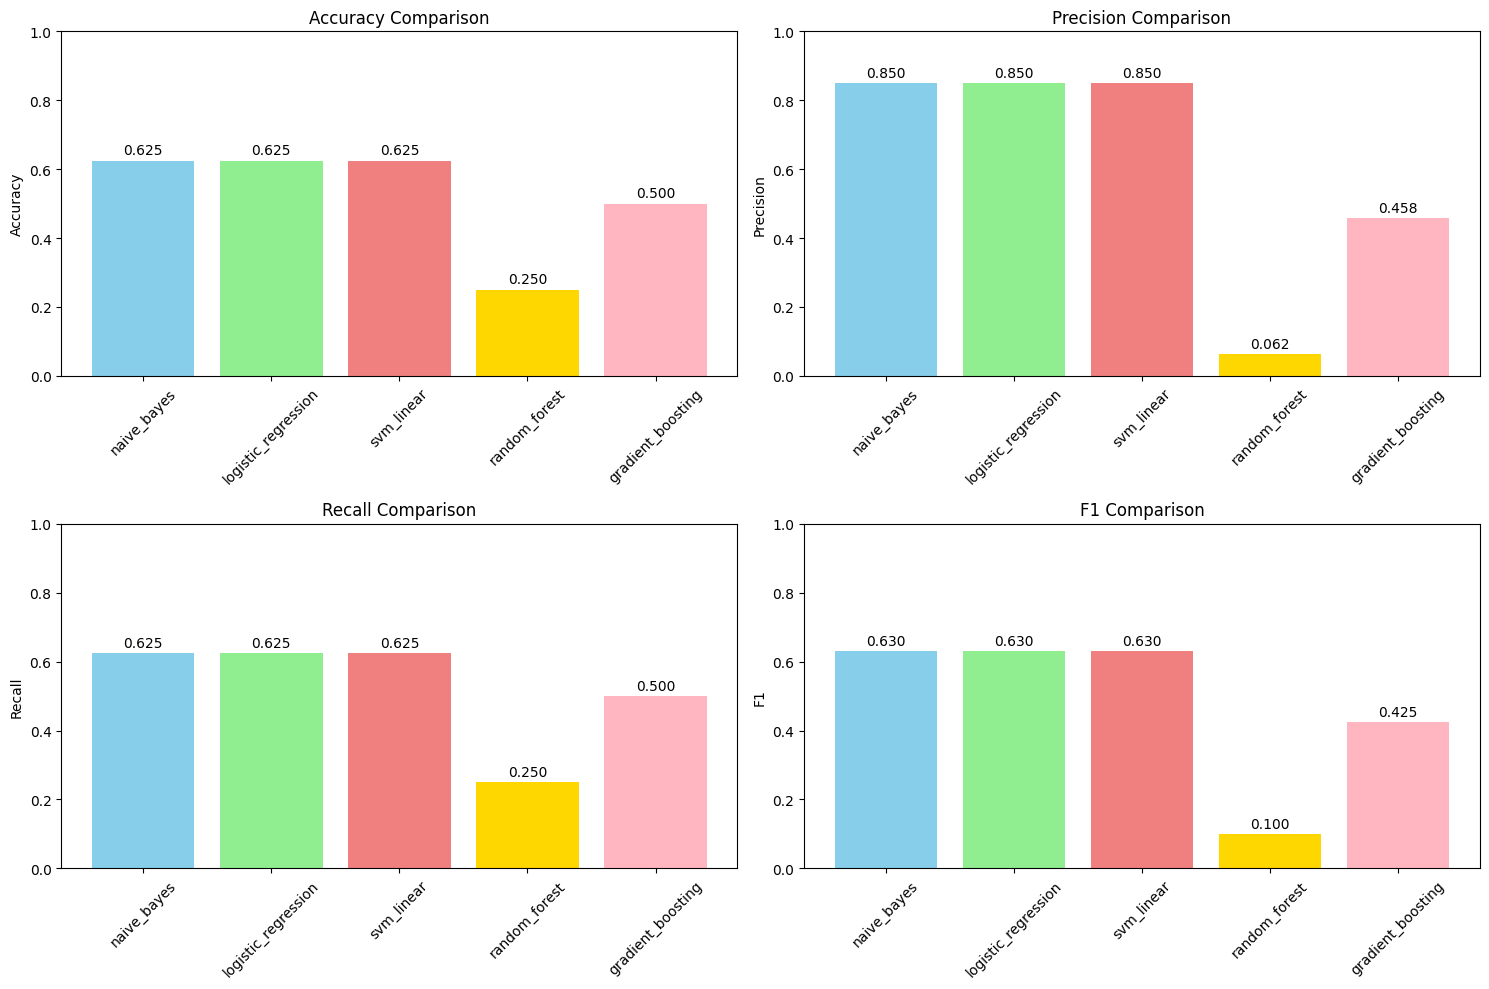


Best performing model: naive_bayes
F1-Score: 0.630


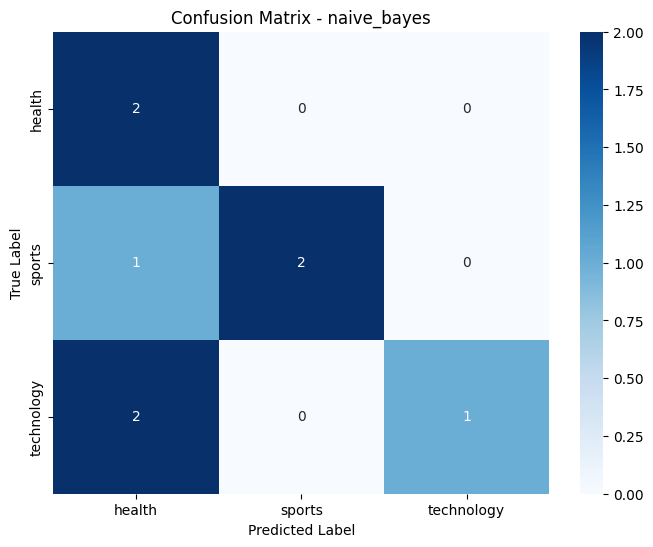


Top Features for Classification:

Predictions on new examples:
Text: Machine learning algorithms process large datasets efficiently.
Predicted: technology
Probabilities: {np.str_('health'): np.float64(0.31128241208754254), np.str_('sports'): np.float64(0.26755089640103136), np.str_('technology'): np.float64(0.4211666915114264)}
--------------------------------------------------
Text: The football team scored a winning goal in overtime.
Predicted: sports
Probabilities: {np.str_('health'): np.float64(0.33577915327940233), np.str_('sports'): np.float64(0.37981036172697147), np.str_('technology'): np.float64(0.2844104849936259)}
--------------------------------------------------
Text: Regular checkups help maintain good health and prevent diseases.
Predicted: health
Probabilities: {np.str_('health'): np.float64(0.49115948055749986), np.str_('sports'): np.float64(0.254820066404696), np.str_('technology'): np.float64(0.2540204530378038)}
--------------------------------------------------


In [16]:
# Visualize model performance
def plot_model_comparison(evaluation_results):
    """Plot model performance comparison"""
    models = list(evaluation_results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()

    for i, metric in enumerate(metrics):
        scores = [evaluation_results[model][metric] for model in models]

        bars = axes[i].bar(models, scores, color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'lightpink'])
        axes[i].set_title(f'{metric.capitalize()} Comparison')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].set_ylim(0, 1)

        # Add value labels on bars
        for bar, score in zip(bars, scores):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{score:.3f}', ha='center', va='bottom')

        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix'):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Visualize results
plot_model_comparison(evaluation_results)

# Plot confusion matrix for best model
best_model = max(evaluation_results.keys(), key=lambda x: evaluation_results[x]['f1'])
print(f"\nBest performing model: {best_model}")
print(f"F1-Score: {evaluation_results[best_model]['f1']:.3f}")

y_pred_best = evaluation_results[best_model]['predictions']
class_labels = classifier.label_encoder.classes_

plot_confusion_matrix(y_test, y_pred_best, class_labels,
                     f'Confusion Matrix - {best_model}')

# Feature importance analysis
print("\nTop Features for Classification:")
print("=" * 40)

feature_importance = classifier.get_feature_importance(best_model, top_n=5)
if feature_importance:
    if isinstance(feature_importance, dict) and 'positive' not in feature_importance:
        # Multi-class classification
        for class_name, features in feature_importance.items():
            print(f"\n{class_name.upper()} class:")
            for feature, weight in features:
                print(f"  {feature}: {weight:.3f}")
    else:
        # Binary classification or tree-based
        print(feature_importance)

# Test predictions on new examples
test_examples = [
    "Machine learning algorithms process large datasets efficiently.",
    "The football team scored a winning goal in overtime.",
    "Regular checkups help maintain good health and prevent diseases."
]

print("\nPredictions on new examples:")
print("=" * 50)

processed_examples = preprocessor.preprocess_corpus(test_examples)
predictions, probabilities = classifier.predict(processed_examples, best_model)

for i, (original, prediction) in enumerate(zip(test_examples, predictions)):
    print(f"Text: {original}")
    print(f"Predicted: {prediction}")
    if probabilities is not None:
        prob_dict = dict(zip(class_labels, probabilities[i]))
        print(f"Probabilities: {prob_dict}")
    print("-" * 50)

---

# Text Classification Challenges





### Challenge 1: Feature Engineering Enhancement
Enhance the feature extraction process with additional linguistic and statistical features.

**Requirements:**
- Add part-of-speech (POS) tag features
- Include readability metrics (Flesch-Kincaid, etc.)
- Implement domain-specific feature extraction

**Success Criteria:**
- Implement at least 10 new features
- Improve classification accuracy by 5%+
- Create feature importance analysis

In [ ]:
# Your solution for Challenge 1
import textstat
from sklearn.decomposition import PCA
import spacy

nlp = spacy.load("en_core_web_sm")

class EnhancedFeatureExtractor:
    def __init__(self):
        self.domain_keywords = {
            "finance": ["revenue", "cost", "profit", "loss", "assets"],
            "medical": ["diagnosis", "treatment", "symptom", "therapy", "disease"]
        }

    def extract_pos_features(self, texts):
        features = []
        for doc in nlp.pipe(texts, disable=["ner"]):
            pos_counts = Counter([token.pos_ for token in doc])
            total_tokens = len([token for token in doc if not token.is_punct])
            pos_dict = {
                'noun_ratio': pos_counts.get("NOUN", 0) / total_tokens if total_tokens else 0,
                'verb_ratio': pos_counts.get("VERB", 0) / total_tokens if total_tokens else 0,
                'adj_ratio': pos_counts.get("ADJ", 0) / total_tokens if total_tokens else 0,
                'adv_ratio': pos_counts.get("ADV", 0) / total_tokens if total_tokens else 0,
                'function_to_content_ratio': sum(pos_counts.get(p, 0) for p in ['DET', 'ADP', 'CCONJ', 'PRON']) / total_tokens if total_tokens else 0
            }
            features.append(pos_dict)
        return pd.DataFrame(features)

    def extract_readability_features(self, texts):
        features = []
        for text in texts:
            feats = {
                'flesch_reading_ease': textstat.flesch_reading_ease(text),#how easy to read
                'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text), #grade level required to understand
                'gunning_fog_index': textstat.gunning_fog(text) ,#years of education needed
                'automated_readability_index': textstat.automated_readability_index(text), #similar to gunning
                'smog_index': textstat.smog_index(text),
                'avg_sentence_length': textstat.avg_sentence_length(text),
                'avg_syllables_per_word': textstat.avg_syllables_per_word(text)
            }
            features.append(feats)
        return pd.DataFrame(features)

    def extract_domain_features(self, texts, domain='general'):
        keywords = self.domain_keywords.get(domain, [])
        features = []
        for text in texts:
            text_lower = text.lower()
            term_count = sum(text_lower.count(term) for term in keywords)
            acronym_count = len(re.findall(r'\b[A-Z]{2,}\b', text))
            named_entities = len([ent for ent in nlp(text).ents])
            features.append({
                'domain_term_count': term_count,
                'acronym_ratio': acronym_count / len(text.split()) if text.split() else 0,
                'named_entity_count': named_entities
            })
        return pd.DataFrame(features)

    def combine_all_features(self, texts, domain='general'):
        pos_df = self.extract_pos_features(texts)
        readability_df = self.extract_readability_features(texts)
        domain_df = self.extract_domain_features(texts, domain)
        return pd.concat([pos_df, readability_df, domain_df], axis=1)

# Example test
if __name__ == "__main__":
    test_texts = [
        "The quarterly financial report shows a significant increase in revenue.",
        "Symptoms include fever, cough, and shortness of breath. Immediate treatment is recommended.",
        "Artificial Intelligence is transforming industries and shaping the future."
    ]

    extractor = EnhancedFeatureExtractor()
    feature_df = extractor.combine_all_features(test_texts, domain="finance")
    print(feature_df.round(2))


   noun_ratio  verb_ratio  adj_ratio  adv_ratio  function_to_content_ratio  \
0        0.30        0.10       0.30        0.0                       0.30   
1        0.50        0.17       0.08        0.0                       0.17   
2        0.22        0.22       0.00        0.0                       0.22   

   flesch_reading_ease  flesch_kincaid_grade  gunning_fog_index  \
0                19.03                 13.09              20.00   
1                38.60                  9.37               9.07   
2                 0.30                 15.45              21.38   

   automated_readability_index  smog_index  avg_sentence_length  \
0                        12.77       14.55                 10.0   
1                        12.97        8.84                  6.0   
2                        17.61       14.55                  9.0   

   avg_syllables_per_word  domain_term_count  acronym_ratio  \
0                    2.10                  1            0.0   
1                    1.

### Challenge 2: Imbalanced Dataset Handling
Implement techniques to handle imbalanced text classification datasets.

**Requirements:**
- Create artificially imbalanced dataset
- Implement SMOTE for text data
- Use cost-sensitive learning approaches
- Compare different resampling techniques

**Success Criteria:**
- Handle datasets with 10:1 class imbalance
- Improve F1-score for minority class by 20%+
- Implement at least 3 different balancing techniques

In [18]:
# Your solution for Challenge 2
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight

class ImbalancedTextClassifier:
    def __init__(self):
        # TODO: Initialize imbalanced text classifier
        self.balancing_methods = {}

    def create_imbalanced_dataset(self, texts, labels, imbalance_ratio=0.1):
        # TODO: Create artificially imbalanced dataset
        pass

    def apply_smote(self, X, y):
        # TODO: Apply SMOTE for text data
        pass

    def apply_cost_sensitive_learning(self, X, y):
        # TODO: Implement cost-sensitive learning
        pass

    def compare_balancing_techniques(self, X, y):
        # TODO: Compare different techniques
        pass

# TODO: Test imbalanced dataset handling

##

### Challenge 3: Hierarchical Text Classification
Build a hierarchical text classification system that can handle nested categories.

**Requirements:**
- Create hierarchical label structure
- Implement top-down classification approach
- Handle different levels of the hierarchy
- Evaluate performance at each level

**Success Criteria:**
- Support at least 3 levels of hierarchy
- Achieve 80%+ accuracy at each level
- Implement both flat and hierarchical evaluation metrics

In [19]:
# Your solution for Challenge 3
class HierarchicalTextClassifier:
    def __init__(self):
        # TODO: Initialize hierarchical classifier
        self.hierarchy = {}
        self.level_classifiers = {}

    def build_hierarchy(self, labels):
        # TODO: Build hierarchical structure from labels
        # Example: "technology/ai/machine_learning"
        pass

    def train_level_classifiers(self, texts, hierarchical_labels):
        # TODO: Train classifier for each level
        pass

    def predict_hierarchical(self, texts):
        # TODO: Predict using top-down approach
        pass

    def evaluate_hierarchical(self, texts, true_labels):
        # TODO: Evaluate at each hierarchy level
        pass

# Create hierarchical dataset
hierarchical_labels = [
    "technology/ai/machine_learning",
    "technology/ai/computer_vision",
    "technology/software/web_development",
    "sports/team_sports/football",
    "sports/individual_sports/tennis",
    "health/nutrition/diet",
    "health/fitness/exercise"
]

# TODO: Implement and test hierarchical classification

### Challenge 4: Domain Adaptation
Build a system that can adapt text classifiers from one domain to another with minimal labeled data.

**Requirements:**
- Implement domain adaptation techniques
- Use transfer learning approaches
- Handle domain shift in text data
- Evaluate adaptation performance

**Success Criteria:**
- Achieve 70%+ accuracy on target domain with 20% training data
- Implement at least 2 adaptation techniques
- Show improvement over baseline

In [20]:
# Your solution for Challenge 4
class DomainAdaptationClassifier:
    def __init__(self):
        # TODO: Initialize domain adaptation classifier
        self.source_model = None
        self.target_model = None

    def train_source_domain(self, source_texts, source_labels):
        # TODO: Train model on source domain
        pass

    def adapt_to_target_domain(self, target_texts, target_labels, adaptation_method='fine_tuning'):
        # TODO: Adapt model to target domain
        # Methods: fine_tuning, feature_adaptation, etc.
        pass

    def measure_domain_shift(self, source_texts, target_texts):
        # TODO: Measure domain shift between source and target
        pass

    def evaluate_adaptation(self, target_test_texts, target_test_labels):
        # TODO: Evaluate adaptation performance
        pass

# TODO: Create source and target domain datasets and test adaptation


### Challenge 5: Few-Shot Text Classification
Implement a few-shot learning system that can classify text with very few examples per class.

**Requirements:**
- Implement prototypical networks for text
- Use meta-learning approaches (MAML)
- Handle new classes with 1-5 examples
- Compare with traditional approaches

**Success Criteria:**
- Achieve 60%+ accuracy with 5 examples per class
- Support adding new classes without retraining
- Outperform traditional methods in few-shot scenarios

In [21]:
# Your solution for Challenge 5
import torch.nn.functional as F

class PrototypicalNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        # TODO: Define prototypical network architecture
        pass

    def forward(self, support_set, query_set):
        # TODO: Implement prototypical network forward pass
        pass

class FewShotTextClassifier:
    def __init__(self):
        # TODO: Initialize few-shot classifier
        self.model = None
        self.support_prototypes = {}

    def create_episode(self, texts, labels, n_way=3, k_shot=5, q_query=10):
        # TODO: Create training/testing episodes
        pass

    def train_few_shot(self, training_data, episodes=1000):
        # TODO: Train few-shot learning model
        pass

    def classify_few_shot(self, support_texts, support_labels, query_texts):
        # TODO: Classify using few-shot approach
        pass

    def add_new_class(self, class_name, example_texts):
        # TODO: Add new class with few examples
        pass

# TODO: Implement and test few-shot learning

### Challenge 6: Adversarial Robustness
Build a text classification system that is robust against adversarial attacks.

**Requirements:**
- Implement adversarial attack methods (word substitution, etc.)
- Develop defense mechanisms
- Evaluate robustness metrics
- Compare different defense strategies

**Success Criteria:**
- Maintain 80%+ accuracy under adversarial attacks
- Implement at least 3 attack methods
- Develop effective defense strategies

In [22]:
# Your solution for Challenge 6
class AdversarialTextAttacks:
    def __init__(self):
        # TODO: Initialize adversarial attack methods
        pass

    def synonym_substitution_attack(self, text, model, target_class=None):
        # TODO: Attack using synonym substitution
        pass

    def word_insertion_attack(self, text, model):
        # TODO: Attack using word insertion
        pass

    def character_level_attack(self, text, model):
        # TODO: Attack using character-level perturbations
        pass

class RobustTextClassifier:
    def __init__(self):
        # TODO: Initialize robust classifier
        self.base_model = None
        self.defense_mechanisms = []

    def adversarial_training(self, texts, labels, attack_method):
        # TODO: Train with adversarial examples
        pass

    def input_preprocessing_defense(self, text):
        # TODO: Defend through input preprocessing
        pass

    def ensemble_defense(self, texts):
        # TODO: Defend using model ensemble
        pass

    def evaluate_robustness(self, clean_texts, adversarial_texts, labels):
        # TODO: Evaluate robustness metrics
        pass

# TODO: Implement and test adversarial robustness

## 🎁 **Bonus Challenge: Production-Ready Text Classification System**

Build a complete, production-ready text classification system with all the bells and whistles.

### Requirements:
1. **Scalable Architecture**: Handle millions of documents
2. **Real-time Inference**: < 100ms response time
3. **Model Monitoring**: Track performance degradation
4. **A/B Testing**: Compare model versions
5. **Auto-retraining**: Retrain on new data
6. **Multi-model Ensemble**: Combine multiple approaches
7. **Explainable Predictions**: Provide reasoning
8. **API Documentation**: Complete REST API
9. **Data Pipeline**: ETL for training data
10. **Model Versioning**: Track model evolution

### Success Criteria:
- Handle 10,000+ requests per minute
- 99.9% uptime
- Automated CI/CD pipeline
- Comprehensive monitoring dashboard
- Docker containerization
- Kubernetes deployment ready

In [24]:
!pip3 install redis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 4.3 MB/s eta 0:00:00


In [25]:
# Your solution for Bonus Challenge
from flask import Flask, request, jsonify
import joblib
import logging
from datetime import datetime
import redis
import asyncio

class ProductionTextClassificationSystem:
    def __init__(self):
        # TODO: Initialize production system
        self.app = Flask(__name__)
        self.models = {}  # Model registry
        self.model_versions = {}
        self.performance_metrics = {}
        self.cache = None  # Redis cache
        self.setup_logging()
        self.setup_routes()

    def setup_logging(self):
        # TODO: Set up comprehensive logging
        pass

    def setup_routes(self):
        # TODO: Define API endpoints
        @self.app.route('/classify', methods=['POST'])
        def classify_text():
            # TODO: Text classification endpoint
            pass

        @self.app.route('/batch_classify', methods=['POST'])
        def batch_classify():
            # TODO: Batch classification endpoint
            pass

        @self.app.route('/model_performance', methods=['GET'])
        def get_model_performance():
            # TODO: Model performance metrics
            pass

    def load_model(self, model_path, version):
        # TODO: Load and register model
        pass

    def ensemble_predict(self, text):
        # TODO: Ensemble prediction from multiple models
        pass

    def monitor_performance(self, predictions, true_labels=None):
        # TODO: Monitor model performance
        pass

    def auto_retrain(self, new_data_threshold=1000):
        # TODO: Automatic retraining logic
        pass

    def explain_prediction(self, text, prediction):
        # TODO: Provide prediction explanation
        pass

# Docker configuration example
dockerfile_content = """
# TODO: Write Dockerfile for containerization
FROM python:3.9-slim

WORKDIR /app

COPY requirements.txt .
RUN pip install -r requirements.txt

COPY . .

EXPOSE 5000

CMD ["python", "app.py"]
"""

# Kubernetes deployment example
k8s_deployment = """
# TODO: Write Kubernetes deployment YAML
apiVersion: apps/v1
kind: Deployment
metadata:
  name: text-classifier
spec:
  replicas: 3
  selector:
    matchLabels:
      app: text-classifier
  template:
    metadata:
      labels:
        app: text-classifier
    spec:
      containers:
      - name: text-classifier
        image: text-classifier:latest
        ports:
        - containerPort: 5000
"""

# TODO: Complete the production system implementation